# IBM Capstone Project: The Battle of the Neighborhoods


## Open new Indian Restaurant in Toronto,Canada

#### Authored by:Sourav Roy

## Introduction

### In this assignment I will attempt to determine which location is good to open a restaturant in Toronto,Canada
- Using Nominatim library address values will be converted to Lattitude and Longitude Co-ordinates
- Using Foursquare API I will explore the neighbourhood of Bucharest
- Using Foursquare API venue ratings and likes will be obtained
- K-means clustering will be used for clustering
- Folium library will be used for visualizing neighbourhoods,venues and clusters
- Source of Wikipedia URL for Postal Codes of Toronto - https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
- Geo Co-ordinates have been sourced from the following CSV file - http://cocl.us/Geospatial_data

In [1]:
#install libraries .It's a one time activity . If the notebook throws error while importing necessary libraries please uncomment below 3 lines and execute
!pip install geopy    
!pip install folium   
!pip install geocoder
!pip install bs4
!pip install lxml

     |████████████████████████████████| 94 kB 5.6 MB/s  eta 0:00:01
     |████████████████████████████████| 98 kB 7.7 MB/s  eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=af2cd5221d2493e68a0da4443f0024b7066a1b45049c3aaf982006d011eb4c9c
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [2]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries import Complete.')

Libraries import Complete.


#### Get neighbourhood Data of :Toronto, Canada

In [3]:
response = requests.get(url=" https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup=BeautifulSoup(response, 'lxml')
#try to find the tables
table=soup.find("table")
table_rows = table.tbody.find_all("tr")

res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned":
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned" in row[2]: 
            row[2] = row[1]
        res.append(row)

# Dataframe with 3 columns
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])
df.head()

,PostalCode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


In [4]:
# get coordinates of toronto
toronto_address = 'toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(toronto_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(toronto_address, latitude, longitude))

The geograpical coordinate of toronto, Canada are 43.6534817, -79.3839347.


In [5]:
response = requests.get(url=" https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup=BeautifulSoup(response, 'lxml')
#try to find the tables
table=soup.find("table")
table_rows = table.tbody.find_all("tr")

res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned":
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned" in row[2]: 
            row[2] = row[1]
        res.append(row)

# Dataframe with 3 columns
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])
df.head()

,PostalCode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


In [6]:
#remove \n at the end from each colum
df["PostalCode"] = df["PostalCode"].str.replace("\n","")
df["Borough"] = df["Borough"].str.replace("\n","")
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [7]:
#group all neighbourhoods with same postal codes
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn


### Get the latitude and the longitude coordinates of each neighborhood.

In [8]:
#We are not able to get the geohraphical coordinates of the neighborhoods using the Geocoder package, we use the given csv file instead.
df_geo_coor = pd.read_csv("http://cocl.us/Geospatial_data")

df_geo_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
#*join df and df_geo_coor to make it into 1 single dataframe#
df_toronto = pd.merge(df, df_geo_coor, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
df_toronto.head()


,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M1A,Not assigned,Not assigned,NaN,NaN,NaN
1,M1B,Scarborough,"Malvern, Rouge",M1B,43.806686,-79.194353
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",M1C,43.784535,-79.160497
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
4,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917


In [10]:
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)

df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1A,Not assigned,Not assigned,NaN,NaN
1,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
4,M1G,Scarborough,Woburn,43.770992,-79.216917


In [11]:
#drop rows where there is no latitude longitude information
df_toronto.dropna(subset=["Latitude","Longitude"], inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
1,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
4,M1G,Scarborough,Woburn,43.770992,-79.216917
5,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

### add markers to the map

In [13]:
for lat, lng, borough, neighborhood in zip(
        df_toronto['Latitude'], 
        df_toronto['Longitude'], 
        df_toronto['Borough'], 
        df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

### work with only the boroughs that contain the word "Toronto".

In [14]:
# "denc" = [D]owntown Toronto, [E]ast Toronto, [N]orth Toronto, [C]entral Toronto
df_toronto_denc = df_toronto[df_toronto['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_denc.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### map again only for Toronto

In [15]:
map_toronto_denc = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(
        df_toronto_denc['Latitude'], 
        df_toronto_denc['Longitude'], 
        df_toronto_denc['Borough'], 
        df_toronto_denc['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_denc)  

map_toronto_denc

### Load Venues and Analyze Neighborhoods in Toronto

#### We will now be utilizing Foursquare API to retrieve venues of neighbourhood

In [16]:
# The code was removed by Watson Studio for sharing.

In [17]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)
# make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
            
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 
neighborhood_venues = getNeighborhoodVenues (df_toronto_denc['Latitude'], df_toronto_denc['Longitude'], df_toronto_denc['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 277 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,4bd461bc77b29c74a07d9282,43.676821,-79.293942,89,Trail
1,The Beaches,43.676357,-79.293031,The Fox Theatre,4ad4c062f964a520c4f720e3,43.672801,-79.287272,609,Indie Movie Theater
2,The Beaches,43.676357,-79.293031,Ed's Real Scoop,4b37c839f964a5200e4625e3,43.672630,-79.287993,580,Ice Cream Shop
3,The Beaches,43.676357,-79.293031,The Beech Tree,5286b7dd498e8b747c1dfe71,43.680493,-79.288846,570,Gastropub
4,The Beaches,43.676357,-79.293031,Beaches Bake Shop,4c0e40c0c700c9b6e185a3dd,43.680363,-79.289692,520,Bakery


### print top 10 distinct venue counts are as below

In [18]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Coffee Shop,141
Café,113
Park,58
Italian Restaurant,55
Restaurant,48
Bakery,46
Pizza Place,41
Bar,40
Sushi Restaurant,38


### Let's concentrate only on Restaurants by filtering venues 

In [19]:
restaurant_list =['Coffee Shop','Café','Pizza Place','Italian Restaurant','Restaurant','Bakery','Bar','Sushi Restaurant','Thai Restaurant','Sandwich Place','Japanese Restaurant','Indian Restaurant','Breakfast Spot','Vegetarian / Vegan Restaurant','Mexican Restaurant','American Restaurant','Greek Restaurant','French Restaurant','Ice Cream Shop','Fast Food Restaurant','Dessert Shop','Vietnamese Restaurant','Korean Restaurant','Burger Joint','Ramen Restaurant','Seafood Restaurant','Middle Eastern Restaurant','Caribbean Restaurant','Beer Bar']
Indian_Restaurant_list = ['Indian Restaurant','Vegetarian / Vegan Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
indian_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(Indian_Restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(Indian_Restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Indian restaurants:', len(indian_restaurants['VenueId'].unique()))
print('Percentage of Indian restaurants: {:.2f}%'.format(len(indian_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))


Total number of restaurants: 1025
Total number of Indian restaurants: 49
Percentage of Indian restaurants: 4.78%


In [20]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]
print(df_rest_counts)

                                                    RestaurantCount
Neighborhood                                                       
Berczy Park                                                      47
Brockton, Parkdale Village, Exhibition Place                     57
Business reply mail Processing Centre, South Ce...               19
CN Tower, King and Spadina, Railway Lands, Harb...                4
Central Bay Street                                               44
Christie                                                         64
Church and Wellesley                                             51
Commerce Court, Victoria Hotel                                   46
Davisville                                                       66
Davisville North                                                 58
Dufferin, Dovercourt Village                                     34
First Canadian Place, Underground city                           47
Forest Hill North & West, Forest Hill Road Park 

In [21]:
#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))
print(noRestList)

[]


In [22]:
#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#### get counts of Indian restaurants in each Neighborhood


In [23]:
df_indian_rest_counts =  indian_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "IndianRestaurantCount"})[['IndianRestaurantCount']]
print(df_indian_rest_counts)

                                                    IndianRestaurantCount
Neighborhood                                                             
Berczy Park                                                             1
Brockton, Parkdale Village, Exhibition Place                            4
Central Bay Street                                                      2
Christie                                                                4
Church and Wellesley                                                    1
Commerce Court, Victoria Hotel                                          2
Davisville                                                              4
Davisville North                                                        2
First Canadian Place, Underground city                                  2
Forest Hill North & West, Forest Hill Road Park                         1
Garden District, Ryerson                                                1
Harbourfront East, Union Station, Toro

#### find neighborhoods that does not have any Indian restaurant 


In [24]:
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(indian_restaurants['Neighborhood']))
print(noRestList)

['Lawrence Park', 'Business reply mail Processing Centre, South Central Letter Processing Plant Toronto', 'Moore Park, Summerhill East', 'Rosedale', 'Parkdale, Roncesvalles', 'North Toronto West,  Lawrence Park', 'Dufferin, Dovercourt Village', 'CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport', 'Roselawn']


In [25]:
#if exists , append neighborhoods without any indian restaurant to df_indian_rest_counts
if noRestList != []:
    df_indian_rest_counts = df_indian_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'IndianRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))
print(df_indian_rest_counts)    

                                                    IndianRestaurantCount
Neighborhood                                                             
Berczy Park                                                             1
Brockton, Parkdale Village, Exhibition Place                            4
Central Bay Street                                                      2
Christie                                                                4
Church and Wellesley                                                    1
Commerce Court, Victoria Hotel                                          2
Davisville                                                              4
Davisville North                                                        2
First Canadian Place, Underground city                                  2
Forest Hill North & West, Forest Hill Road Park                         1
Garden District, Ryerson                                                1
Harbourfront East, Union Station, Toro

In [26]:
df_indian_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_indian_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Indian restaurant'.format(len(noRestList)))

9 neighborhoods do not have any Indian restaurant


#### Draw Top 10 graph with neighbourhood with most indian restaurant count


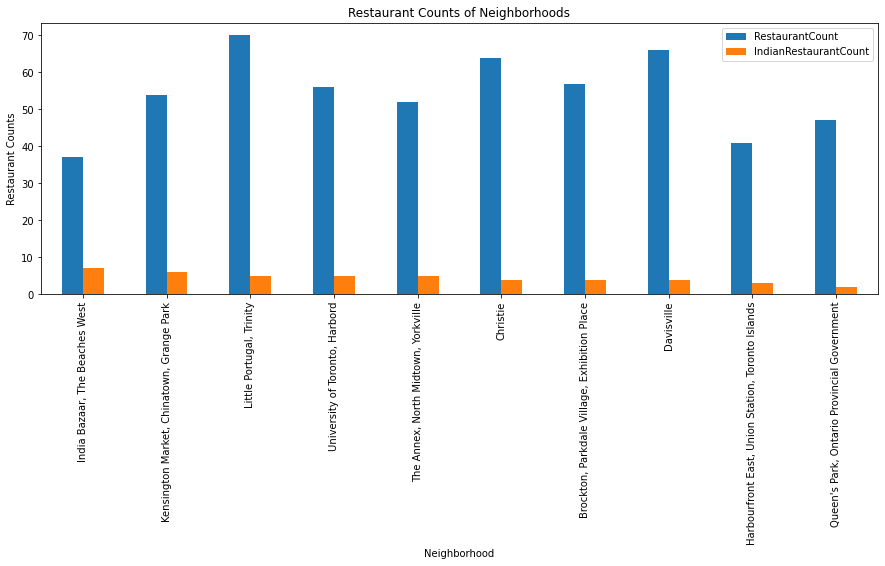

In [27]:
df_rest_counts[['RestaurantCount','IndianRestaurantCount']].sort_values(by='IndianRestaurantCount',ascending=0)[:10].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

#### Draw bottom 10 graph with neighbourhood with most indian restaurant count


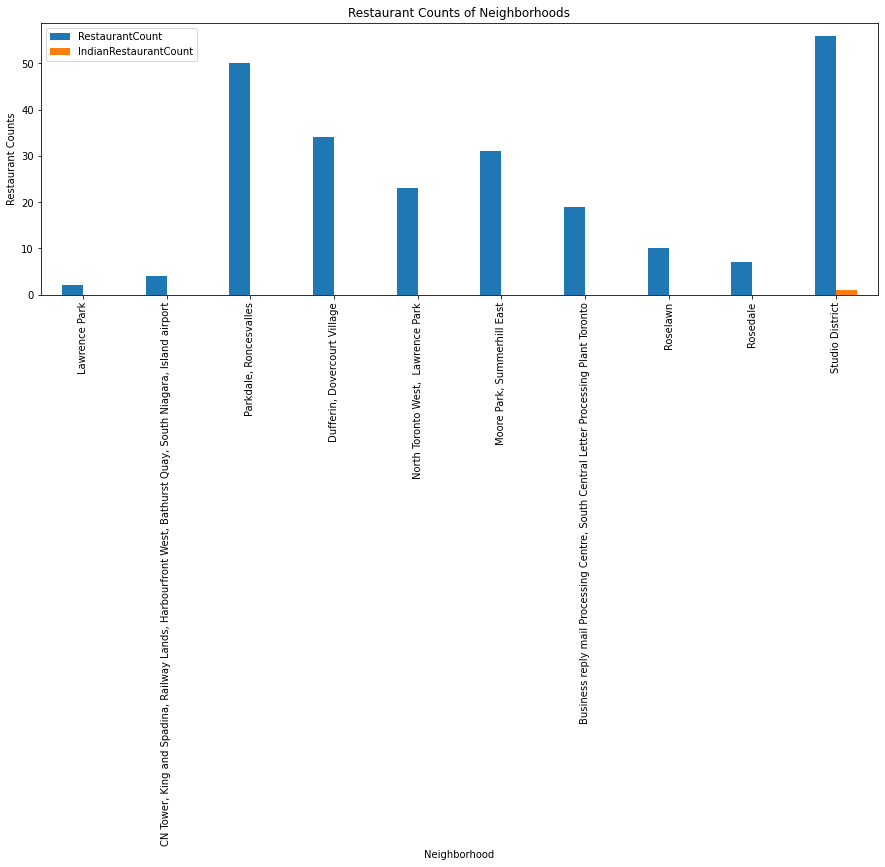

In [28]:
df_rest_counts[['RestaurantCount','IndianRestaurantCount']].sort_values(by='IndianRestaurantCount',ascending=1)[:10].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In [29]:
neighborhood_restaurants.dtypes

Neighborhood       object
Latitude          float64
Longitude         float64
VenueName          object
VenueId            object
VenueLatitude     float64
VenueLongitude    float64
VenueDistance       int64
VenueCategory      object
dtype: object

### Observation
- Kensington Market Chinatown,Grange Park has very high number of restaurants but relatively low number of Indian restaurants
- Moore Park Summer Hill ,East has very high number of restaurants but no Indian restaurants

#### Show restaurants on heat map

#### Let's crete a map showing heatmap / density of restaurants and try to extract some meaningfull info from that. Also, let's show borders of Toronto on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from Toronto center

In [30]:
toronto_center = [latitude, longitude]
map_restaurant= folium.Map(location=toronto_center, zoom_start=12)
df_neighborhood_noindianrest = df_toronto_denc[df_toronto_denc['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_toronto_denc) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)

folium.Marker(toronto_center).add_to(map_toronto)
folium.Circle(toronto_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(toronto_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(toronto_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(toronto_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(indian_restaurants['VenueLatitude'], indian_restaurants['VenueLongitude'], indian_restaurants['Neighborhood'], indian_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

In [31]:
toronto_center = [latitude, longitude]
map_restaurant= folium.Map(location=toronto_center, zoom_start=12)

df_neighborhood_noindianrest = df_toronto_denc[df_toronto_denc['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_toronto) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(toronto_center).add_to(map_toronto)
folium.Circle(toronto_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(toronto_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(toronto_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(toronto_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noindianrest['Latitude'], df_neighborhood_noindianrest['Longitude'], df_neighborhood_noindianrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

### Cluster Neigborhoods using Agglomerative Clustering

In [32]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
#fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
#venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

39  neighborhoods' venue category are shown in 276 columns as below


,Neighborhood,Accessories Store,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio,Zoo
0,Berczy Park,0,0,0,1,0,0,0,0,2,0,0,0,0,0,1,0,2,0,0,0,0,1,1,0,2,0,0,0,1,0,0,0,0

In [33]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10


columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))
print(columns)
#create a new dataframe
venues_most = pd.DataFrame(columns = columns)
for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

['Neighborhood', 'Total Number of Venues', '1st Most Common Restaurant', '2nd Most Common Restaurant', '3rd Most Common Restaurant', '4th Most Common Restaurant', '5th Most Common Restaurant', '6th Most Common Restaurant', '7th Most Common Restaurant', '8th Most Common Restaurant', '9th Most Common Restaurant', '10th Most Common Restaurant']


,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Berczy Park,99,Coffee Shop,Café,Hotel,Japanese Restaurant,Park,Restaurant,Bakery,Grocery Store,Gym,Farmers Market
1,"Brockton, Parkdale Village, Exhibition Place",99,Café,Restaurant,Coffee Shop,Bar,Furniture / Home Store,Bakery,Gift Shop,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Arts & Crafts Store
2,"Business reply mail Processing Centre, South C...",48,Park,Brewery,Pizza Place,Fast Food Restaurant,Sushi Restaurant,Italian Restaurant,Coffee Shop,Pet Store,Pub,Flea Market
3,"CN Tower, King and Spadina, Railway Lands, Har...",15,Harbor / Marina,Coffee Shop,Café,Garden,Park,Airport,Airport Lounge,Dog Run,Sculpture Garden,Scenic Lookout
4,Central Bay Street,99,Coffee Shop,Café,Sushi Restaurant,Park,Ramen Restaurant,Pizza Place,Plaza,Bookstore,Bubble Tea Shop,Burrito Place


### Cluster and find similarities between neighborhoods¶

#### using hierarchical agglomerative clustering method to compare neighborhoods among neighborhoods

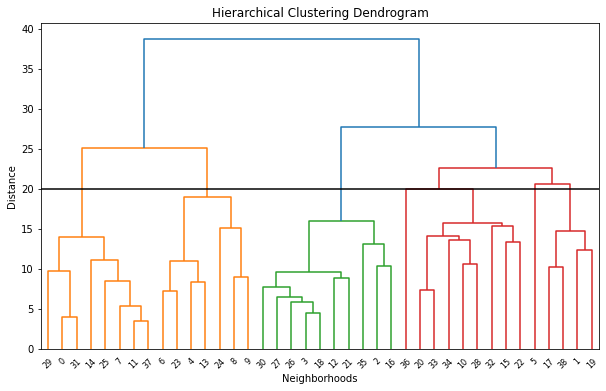

In [34]:
#find the number of clusters. Let's use scipy library to create the dendrograms for our dataset

import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

#### According to the above graph, I decide to separate our neighborhoods into 5 clusters.I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [35]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 5
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_toronto_denc.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Pub,Coffee Shop,Pizza Place
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Café,Pub
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,2,Indian Restaurant,Coffee Shop,Fast Food Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Coffee Shop,Brewery,Vietnamese Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Bookstore,Café,Pharmacy


In [36]:
print(venues_cluster.groupby(['Borough','NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['Borough','NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                                 Neighborhood Count
Borough          NeighborhoodCluster 1st Most Common Restaurant                    
Central Toronto  1                   Café                                         1
                                     Coffee Shop                                  1
                                     Park                                         1
                 2                   Bookstore                                    1
                                     Café                                         2
                                     Italian Restaurant                           1
                 4                   Coffee Shop                                  2
Downtown Toronto 0                   Café                                         2
                                     Korean Restaurant                            1
                 2                   Harbor / Marina                        

Neighborhood Count
Borough          NeighborhoodCluster 2nd Most Common Restaurant                       
Central Toronto  1                   Grocery Store                                   1
                                     Italian Restaurant                              1
                                     Sushi Restaurant                                1
                 2                   Café                                            1
                                     Coffee Shop                                     1
                                     Gym / Fitness Center                            1
                                     Sushi Restaurant                                1
                 4                   Italian Restaurant                              2
Downtown Toronto 0                   Café                                            1
                                     Vegetarian / Vegan Restaurant                   2
                 2                   Coffee Shop                                     1
                                     Grocery Store                                   1
                                     Park                                            1
                 3                   Café                                            8
                 4                   Café                                            2
                                     Gastropub                                       1
                                     Park                                            2
East Toronto     1                   Brewery                                         1
                                     Café                                            1
                 2                   Brewery                                         1
                                     Coffee Shop                                     2
West Toronto     0                   Bar                                             1
                                     Restaurant                                      1
                 1                   Bar                                             1
                                     Café                                            1
                                     Coffee Shop                                     2

## Conclusion
it is fairly evident that except East Toronto all the other sectors are actually a potential candidate borough to setup an Indian Restaurant

-I would choose "RoseDale" as it does not have any Indian Restaurant . More over despite being fairly close to the central Toronto it has only 6 restaurants in total.